In [1]:
from IPython.display import Image, display

In [2]:
import os
os.listdir("images")

['banana.jpeg',
 'bananas.jpeg',
 'car1.jpg',
 'couchtv.jpeg',
 'laptop.jpeg',
 'spoon.jpeg',
 'spoon2.jpeg',
 'toothbrush.jpeg']


Displaying image: banana.jpeg


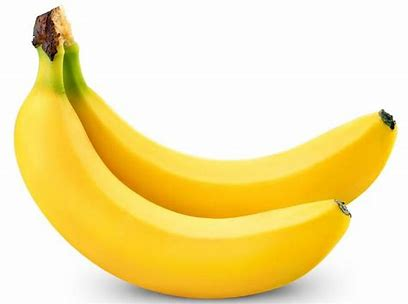


Displaying image: bananas.jpeg


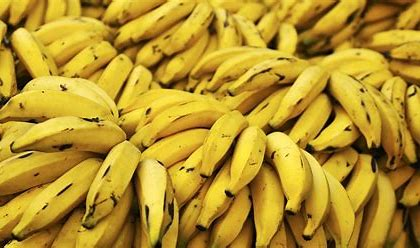


Displaying image: car1.jpg


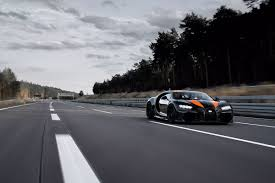


Displaying image: couchtv.jpeg


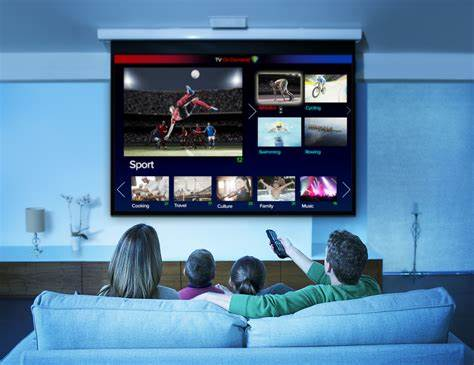


Displaying image: laptop.jpeg


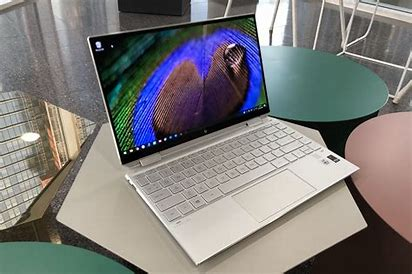


Displaying image: spoon.jpeg


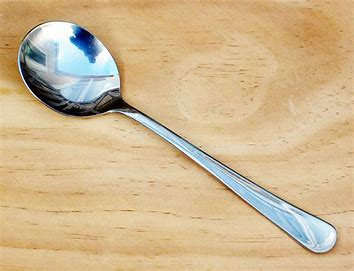


Displaying image: spoon2.jpeg


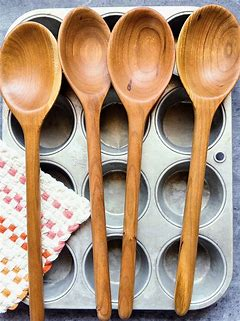


Displaying image: toothbrush.jpeg


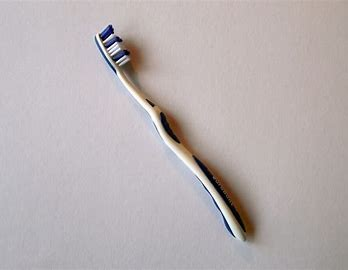

In [3]:
for image in os.listdir("images"):
    print(f"\nDisplaying image: {image}")
    display(Image(filename=f"images/{image}"))

In [4]:
directory = "images_with_drawn_boxes"
if not os.path.exists(directory):
    os.mkdir(directory)

In [5]:
import cv2
import cvlib as cv
from cvlib.object_detection import draw_bbox


def detect_and_draw_box(filename, model="yolov3-tiny", confidence=0.5):
    """Detects common objects on an image and creates a new image with bounding boxes.

    Args:
        filename (str): Filename of the image.
        model (str): Either "yolov3" or "yolov3-tiny". Defaults to "yolov3-tiny".
        confidence (float, optional): Desired confidence level. Defaults to 0.5.
    """
    
    img_filepath = f'images/{filename}'
    
    # Read the image into a numpy array
    img = cv2.imread(img_filepath)
    
    bbox, label, conf = cv.detect_common_objects(img, confidence=confidence, model=model)
    
    # Print current image's filename
    print(f"========================\nImage processed: {filename}\n")
    
    # Print detected objects with confidence level
    for l, c in zip(label, conf):
        print(f"Detected object: {l} with confidence level of {c}\n")
    
    # Create a new image that includes the bounding boxes
    output_image = draw_bbox(img, bbox, label, conf)
    
    cv2.imwrite(f'images_with_drawn_boxes/{filename}', output_image)
    
    display(Image(f'images_with_drawn_boxes/{filename}'))

Image processed: banana.jpeg



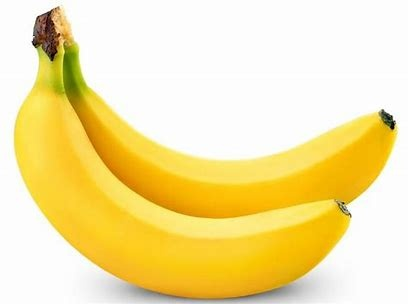

Image processed: bananas.jpeg



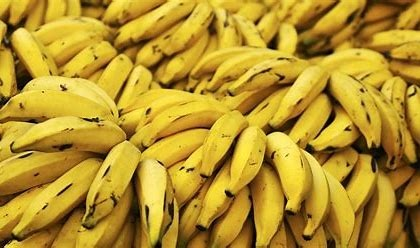

Image processed: car1.jpg

Detected object: car with confidence level of 0.9725152254104614



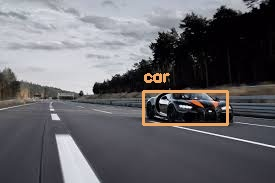

Image processed: couchtv.jpeg



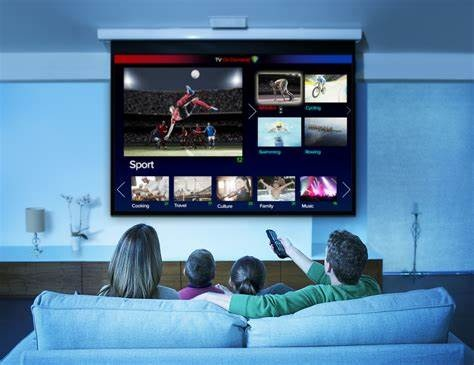

Image processed: laptop.jpeg

Detected object: laptop with confidence level of 0.6210806369781494



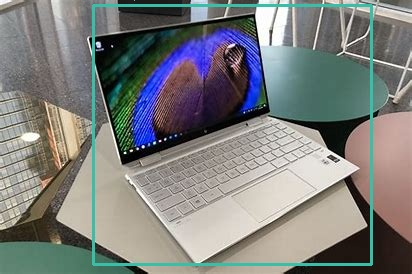

Image processed: spoon.jpeg



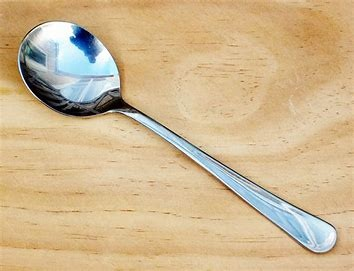

Image processed: spoon2.jpeg



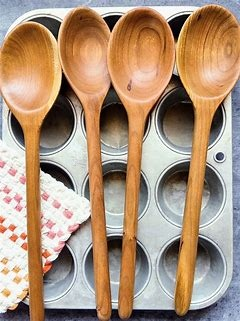

Image processed: toothbrush.jpeg



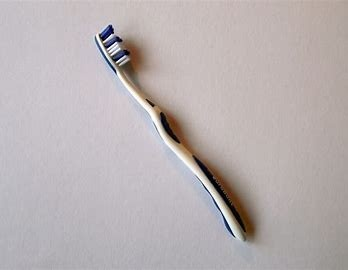

In [6]:
for image in os.listdir("images"):
    detect_and_draw_box(image)

Image processed: couchtv.jpeg



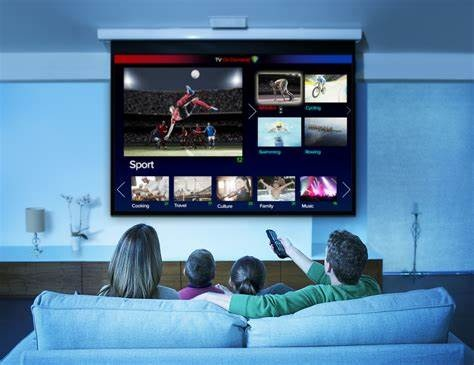

In [7]:
detect_and_draw_box("couchtv.jpeg")

Image processed: couchtv.jpeg

Detected object: person with confidence level of 0.4078039526939392

Detected object: tv with confidence level of 0.356952965259552



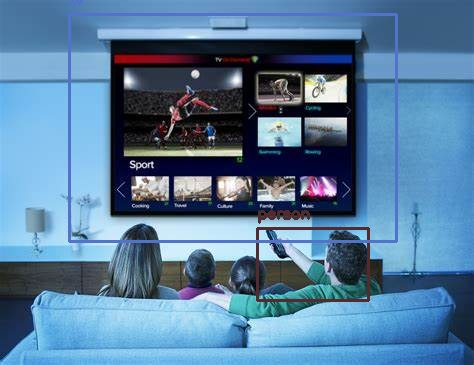

In [8]:
detect_and_draw_box("couchtv.jpeg", confidence=0.2)

Image processed: bananas.jpeg



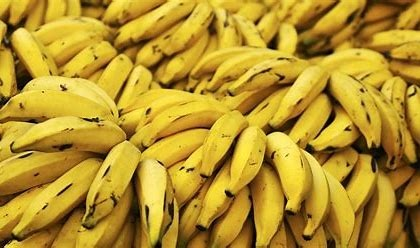

In [9]:
detect_and_draw_box("bananas.jpeg")

Image processed: bananas.jpeg

Detected object: banana with confidence level of 0.41610902547836304

Detected object: banana with confidence level of 0.21158409118652344



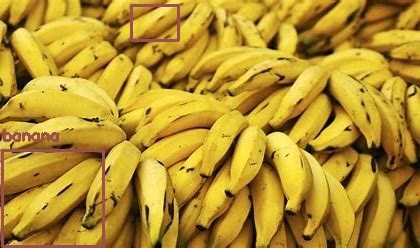

In [10]:
detect_and_draw_box("bananas.jpeg", confidence=0.2)

In [11]:
directory = "received_images"
if not os.path.exists(directory):
    os.mkdir(directory)

In [12]:
import io
import uvicorn
import numpy as np
import nest_asyncio
from enum import Enum
from fastapi import FastAPI, UploadFile, File, HTTPException
from fastapi.responses import StreamingResponse

In [13]:
# Assign an instance of the FastAPI class to the variable "app".
# You will interact with your api using this instance.
app = FastAPI(title='Deploying YOLO Model with FastAPI')

# List available models using Enum for convenience. This is useful when the options are pre-defined.
class Model(str, Enum):
    yolov3tiny = "yolov3-tiny"
    yolov3 = "yolov3"


# By using @app.get("/") you are allowing the GET method to work for the / endpoint.
@app.get("/")
def home():
    return "Congratulations! Your API is working as expected. Now head over to http://localhost:8000/docs."


# This endpoint handles all the logic necessary for the object detection to work.
# It requires the desired model and the image in which to perform object detection.
@app.post("/predict") 
def prediction(model: Model, confidence: float, file: UploadFile = File(...)):

    # Getting the accepted file format
    filename = file.filename
    fileExtension = filename.split(".")[-1] in ("jpg", "jpeg", "png")
    if not fileExtension:
        raise HTTPException(status_code=415, detail="Unsupported file provided.")
    
    # 2. TRANSFORM RAW IMAGE INTO CV2 image
    
    # Read image as a stream of bytes
    image_stream = io.BytesIO(file.file.read())
    
    # Start the stream from the beginning (position zero)
    image_stream.seek(0)
    
    # Write the stream of bytes into a numpy array
    file_bytes = np.asarray(bytearray(image_stream.read()), dtype=np.uint8)
    
    # Decode the numpy array as an image
    image = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
    
    
    # 3. RUN OBJECT DETECTION MODEL
    
    # Run object detection
    bbox, label, conf = cv.detect_common_objects(image, confidence=confidence, model=model)
    
    # Create image that includes bounding boxes and labels
    output_image = draw_bbox(image, bbox, label, conf)
    
    # Save it in a folder within the server
    cv2.imwrite(f'received_images/{filename}', output_image)
    
    
    # 4. STREAM THE RESPONSE BACK TO THE CLIENT
    
    # Open the saved image for reading in binary mode
    file_image = open(f'received_images/{filename}', mode="rb")
    
    # Return the image as a stream specifying media type
    return StreamingResponse(file_image, media_type="image/jpeg")

In [ ]:
# Allows the server to be run in this interactive environment
nest_asyncio.apply()

host = "127.0.0.1"

# Spin up the server!    
uvicorn.run(app, host=host, port=8000)

INFO:     Started server process [37928]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


INFO:     127.0.0.1:57953 - "GET / HTTP/1.1" 200 OK
INFO:     127.0.0.1:57958 - "GET /docs HTTP/1.1" 200 OK
INFO:     127.0.0.1:57958 - "GET /openapi.json HTTP/1.1" 200 OK
INFO:     127.0.0.1:57959 - "POST /predict?model=yolov3-tiny&confidence=0.1 HTTP/1.1" 200 OK
INFO:     127.0.0.1:58065 - "POST /predict?model=yolov3-tiny&confidence=0.2 HTTP/1.1" 200 OK
INFO:     127.0.0.1:58069 - "POST /predict?model=yolov3-tiny&confidence=0.2 HTTP/1.1" 200 OK
INFO:     127.0.0.1:58071 - "POST /predict?model=yolov3-tiny&confidence=0.2 HTTP/1.1" 200 OK
INFO:     127.0.0.1:58073 - "POST /predict?model=yolov3-tiny&confidence=0.2 HTTP/1.1" 200 OK
